# Programming and Mathematics for AI: Task 4

# Part 1: Implement a Neural Network (Baseline)

Imports

In [1]:
# NumPy
import numpy as np

# PyTorch - Open-source machine learning framework
import torch
import torch.nn as nn # Neural network
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

#Torchvision - Package consisting of popular datasets, model architectures, and common image transformations for computer vision
import torchvision
# from torchvision import datasets # Possibly remove
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 # Dataset
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Matplotlib - Visualising data
import matplotlib.pyplot as plt
%matplotlib inline


Downloading CIFAR-10 dataset, and examining its contents. 50,000 images are intended for training, and 10,000 for testing.  We will split this further by including a validation set of 5,000 images from the training set.

In [2]:
training_data = CIFAR10(root = 'data/', download = True, transform = ToTensor())

testing_data = CIFAR10(root = 'data/', train = False, transform = ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [3]:
classes = training_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
training_data_size = len(training_data)
training_data_size

50000

In [5]:
testing_data_size = len(testing_data)
testing_data_size

10000

In [6]:
classes_count = len(training_data.classes)
classes_count

10

In [7]:
# Image shape
image, label = training_data[0]
image_shape = image.shape
image_shape

torch.Size([3, 32, 32])

Further splitting data to get a validation set.  Using a seed value to ensure the same validation set is always used.

In [8]:
# Validation data size
validation_size = 5000
# New training data size
training_size = len(training_data) - validation_size
# Random seed for reproducibility
torch.manual_seed(25)

Using random split on training data to allocate 5,000 images to validation.

In [9]:
training_data, validation_data = random_split(training_data, [training_size, validation_size])

# Final datasets
print(len(training_data)) # Data used to fit the model
print(len(validation_data)) # Data used to fine-tune the model hyperparameters
print(len(testing_data)) # Data used to provide an unbiased evaluation of a final NN

45000
5000
10000


Baseline Parameters

Batch size defines the number of samples that will be propagated through the neural network, number of epochs determines training times, optimiser function has several options.  Learning rate describes the rate at which the model optimises.

In [10]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

Data loaders for training, validation, testing sets.  We used shuffle for the training data loader so that batches are different per epoch during training.  This boosts generalisation. 2 workers are used, as recommended by colab.

In [11]:
training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)

testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

# Building the Neural Network

Function to determine model accuracy

In [12]:
def determine_accuracy(outputs, labels):
    """Determine accuracy via predictions"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class NeuralNetwork(nn.Module):

    def train_batch(self, batch):
        """Training batch: making predictions and determining loss"""

        batch_images, batch_labels = batch

        # Make predictions
        out = self(batch_images)

        # Determine batch loss
        batch_loss = F.cross_entropy(out, batch_labels)
        return batch_loss
    
    def validate_batch(self, batch):
        """Validating batch: making predictions, determining loss and accuracy"""

        batch_images, batch_labels = batch

        # Make predictions
        out = self(batch_images)

        # Determine loss
        batch_loss = F.cross_entropy(out, batch_labels)

        # Calculate accuracy
        accuracy = determine_accuracy(out, batch_labels)
        return {'validation_loss': batch_loss.detach(), 'validation_accuracy': accuracy}
        
    def validate_epoch(self, outputs):
        """Validate batches at the end of epoch"""

        # Losses across epochs
        epoch_losses = [x['validation_loss'] for x in outputs]

        # Combining losses using mean
        combined_epoch_loss = torch.stack(epoch_losses).mean()

        # Accuracies across epochs
        epoch_accs = [x['validation_accuracy'] for x in outputs]

        # Combining accuracies using mean
        combined_epoch_acc = torch.stack(epoch_accs).mean()

        return {'validation_loss': combined_epoch_loss.item(), 'validation_accuracy': combined_epoch_acc.item()}
    
    def print_epoch(self, epoch, result):
        """Print epoch number, validation loss and accuracy at the end of each epoch"""

        print("Epoch {} | validation_loss: {:.4f} | validation_accuracy: {:.4f}".format(epoch, result['validation_loss'], result['validation_accuracy']))

Function to evaluate model using model's internal functions

In [14]:
def validate_model(model, validation_loader):
    """Model validation"""

    outputs = [model.validate_batch(batch) for batch in validation_loader]
    return model.validate_epoch(outputs)


Function to train model using evaluation function above, and model's internal training functions.

In [15]:
def fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function):
    """Model training and validation"""

    # Model history
    model_history = []

    # Model optimiser
    model_optimiser = optimiser_function(model.parameters(), learning_rate)

    for epoch in range(epochs):

        # Training
        for batch in training_loader:

            loss = model.train_batch(batch)
            loss.backward()

            model_optimiser.step()
            model_optimiser.zero_grad()

        # Validation
        result = validate_model(model, validation_loader)
        model.print_epoch(epoch, result)
        model_history.append(result)

    return model_history

Checking the use of a dedicated GPU: In our case we mostly used CPUs.

In [16]:
def get_device():
    """Use dedicated GPU if available, else use CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [17]:
device = get_device()
print(device)

cpu


In [18]:
def move_to_device(data, device):
    """Move data to GPU/CPU"""
    if isinstance(data, (list,tuple)):
        # Using recursion if required
        return [move_to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)


Function to plot loss across model history.

In [19]:
def plot_losses(history):
    """Plot loss across model history"""

    losses = [x['validation_loss'] for x in history]

    # Plotting using pyplot
    plt.plot(losses, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss against epochs');

Function to plot accuracy across model history.

In [20]:
def plot_accuracies(history):
    """Plot accuracy across model history"""

    accuracies = [x['validation_accuracy'] for x in history]

    # Plotting using pyplot
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy against epochs');

Data Loaders

In [21]:

class DeviceDataLoader():
    """Move data to a device"""

    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
      
    def __len__(self):
        """Batch count"""

        return len(self.data_loader)
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        
        for b in self.data_loader: 
            yield move_to_device(b, self.device)

    

In [22]:
training_loader = DeviceDataLoader(training_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
testing_loader = DeviceDataLoader(testing_loader, device)

# Training the Neural Network

In [23]:
# Input and output

input_size = 3*32*32

output_size = 10

In [24]:
class Model_1(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

Move model to device

In [25]:
model = move_to_device(Model_1(), device)

In [26]:
history = [validate_model(model, validation_loader)]
print(history)

[{'validation_loss': 2.304971694946289, 'validation_accuracy': 0.12934282422065735}]


In [27]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.9605 | validation_accuracy: 0.2781
Epoch 1 | validation_loss: 1.7406 | validation_accuracy: 0.3785
Epoch 2 | validation_loss: 1.7545 | validation_accuracy: 0.3676
Epoch 3 | validation_loss: 1.7191 | validation_accuracy: 0.3739
Epoch 4 | validation_loss: 1.6077 | validation_accuracy: 0.4213
Epoch 5 | validation_loss: 1.5913 | validation_accuracy: 0.4380
Epoch 6 | validation_loss: 1.5850 | validation_accuracy: 0.4263
Epoch 7 | validation_loss: 1.6291 | validation_accuracy: 0.4145
Epoch 8 | validation_loss: 1.4978 | validation_accuracy: 0.4650
Epoch 9 | validation_loss: 1.5688 | validation_accuracy: 0.4414


Initial results

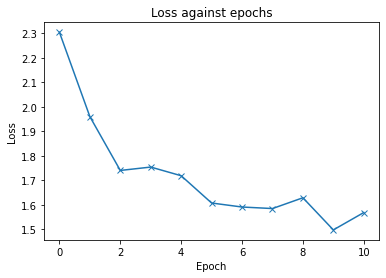

In [28]:
plot_losses(history)

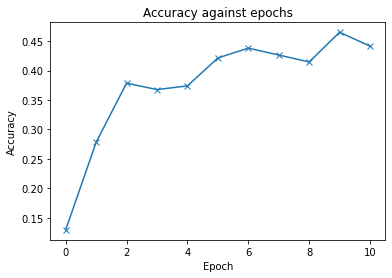

In [29]:
plot_accuracies(history)

In [30]:
learning_rate = 1e-2

In [31]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.4103 | validation_accuracy: 0.4965
Epoch 1 | validation_loss: 1.4036 | validation_accuracy: 0.5026
Epoch 2 | validation_loss: 1.4050 | validation_accuracy: 0.5000
Epoch 3 | validation_loss: 1.3969 | validation_accuracy: 0.4999
Epoch 4 | validation_loss: 1.3950 | validation_accuracy: 0.5037
Epoch 5 | validation_loss: 1.3949 | validation_accuracy: 0.5008
Epoch 6 | validation_loss: 1.3830 | validation_accuracy: 0.5082
Epoch 7 | validation_loss: 1.3925 | validation_accuracy: 0.5030
Epoch 8 | validation_loss: 1.3801 | validation_accuracy: 0.5099
Epoch 9 | validation_loss: 1.3848 | validation_accuracy: 0.5050


In [32]:
learning_rate = 1e-3

In [33]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.3705 | validation_accuracy: 0.5099
Epoch 1 | validation_loss: 1.3735 | validation_accuracy: 0.5075
Epoch 2 | validation_loss: 1.3715 | validation_accuracy: 0.5081
Epoch 3 | validation_loss: 1.3688 | validation_accuracy: 0.5124
Epoch 4 | validation_loss: 1.3769 | validation_accuracy: 0.5063
Epoch 5 | validation_loss: 1.3719 | validation_accuracy: 0.5078
Epoch 6 | validation_loss: 1.3693 | validation_accuracy: 0.5083
Epoch 7 | validation_loss: 1.3687 | validation_accuracy: 0.5110
Epoch 8 | validation_loss: 1.3715 | validation_accuracy: 0.5092
Epoch 9 | validation_loss: 1.3679 | validation_accuracy: 0.5104


Plotting losses across all epochs

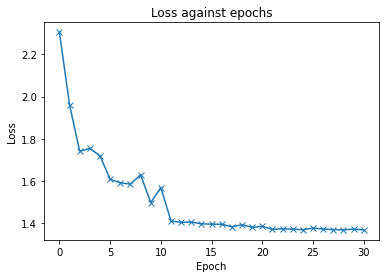

In [34]:
plot_losses(history)

Plotting accuracies across all epochs

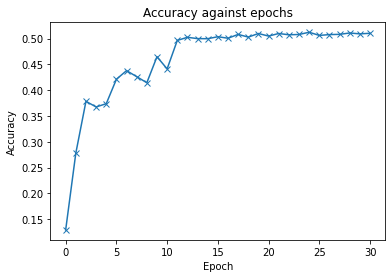

In [35]:
plot_accuracies(history)

Evaluating model using the testing data and validate_model function

In [36]:
validate_model(model, testing_loader)

{'validation_accuracy': 0.5194336175918579,
 'validation_loss': 1.3510839939117432}

In [37]:
# ...

# Part 2: Propose Improvements (TO-DO)

# Part 3: Tuning Parameters

Running baseline model while varying number of epochs: 10, 25, 50

In [48]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.302868604660034, 'validation_accuracy': 0.09181985259056091}]
Epoch 0 | validation_loss: 1.9057 | validation_accuracy: 0.3091
Epoch 1 | validation_loss: 1.7816 | validation_accuracy: 0.3672
Epoch 2 | validation_loss: 1.7181 | validation_accuracy: 0.3884
Epoch 3 | validation_loss: 1.6154 | validation_accuracy: 0.4258
Epoch 4 | validation_loss: 1.6809 | validation_accuracy: 0.4034
Epoch 5 | validation_loss: 1.5522 | validation_accuracy: 0.4492
Epoch 6 | validation_loss: 1.5830 | validation_accuracy: 0.4378
Epoch 7 | validation_loss: 1.5884 | validation_accuracy: 0.4407
Epoch 8 | validation_loss: 1.5605 | validation_accuracy: 0.4398
Epoch 9 | validation_loss: 1.5396 | validation_accuracy: 0.4506


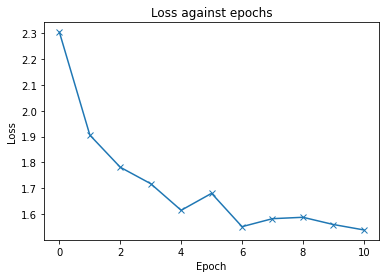

In [49]:
plot_losses(history)

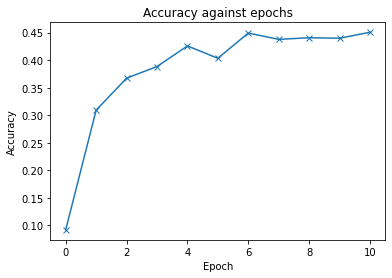

In [50]:
plot_accuracies(history)

In [51]:
epochs = 25
model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.305187940597534, 'validation_accuracy': 0.1076861172914505}]
Epoch 0 | validation_loss: 1.8609 | validation_accuracy: 0.3250
Epoch 1 | validation_loss: 1.8176 | validation_accuracy: 0.3489
Epoch 2 | validation_loss: 1.7805 | validation_accuracy: 0.3618
Epoch 3 | validation_loss: 1.7731 | validation_accuracy: 0.3560
Epoch 4 | validation_loss: 1.5645 | validation_accuracy: 0.4451
Epoch 5 | validation_loss: 1.5550 | validation_accuracy: 0.4442
Epoch 6 | validation_loss: 1.5639 | validation_accuracy: 0.4336
Epoch 7 | validation_loss: 1.6025 | validation_accuracy: 0.4278
Epoch 8 | validation_loss: 1.5151 | validation_accuracy: 0.4666
Epoch 9 | validation_loss: 1.5500 | validation_accuracy: 0.4562
Epoch 10 | validation_loss: 1.5499 | validation_accuracy: 0.4533
Epoch 11 | validation_loss: 1.4979 | validation_accuracy: 0.4575
Epoch 12 | validation_loss: 1.4702 | validation_accuracy: 0.4715
Epoch 13 | validation_loss: 1.7041 | validation_accuracy: 0.4146
Epoch 14 | valid

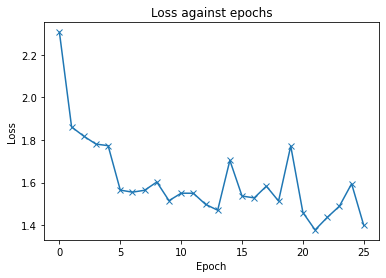

In [52]:
plot_losses(history)

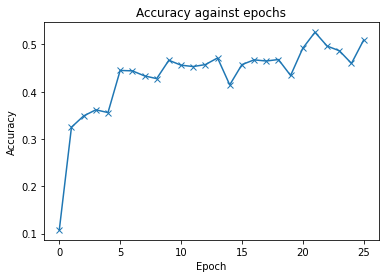

In [53]:
plot_accuracies(history)

In [54]:
epochs = 50
model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3034586906433105, 'validation_accuracy': 0.1040441170334816}]
Epoch 0 | validation_loss: 1.9770 | validation_accuracy: 0.2998
Epoch 1 | validation_loss: 1.9657 | validation_accuracy: 0.3112
Epoch 2 | validation_loss: 1.8663 | validation_accuracy: 0.3199
Epoch 3 | validation_loss: 1.7109 | validation_accuracy: 0.3875
Epoch 4 | validation_loss: 1.5723 | validation_accuracy: 0.4393
Epoch 5 | validation_loss: 1.6423 | validation_accuracy: 0.4138
Epoch 6 | validation_loss: 1.5437 | validation_accuracy: 0.4455
Epoch 7 | validation_loss: 1.6702 | validation_accuracy: 0.4135
Epoch 8 | validation_loss: 1.6054 | validation_accuracy: 0.4265
Epoch 9 | validation_loss: 1.7336 | validation_accuracy: 0.4064
Epoch 10 | validation_loss: 1.5142 | validation_accuracy: 0.4564
Epoch 11 | validation_loss: 1.5500 | validation_accuracy: 0.4493
Epoch 12 | validation_loss: 1.5062 | validation_accuracy: 0.4590
Epoch 13 | validation_loss: 1.4633 | validation_accuracy: 0.4835
Epoch 14 | vali

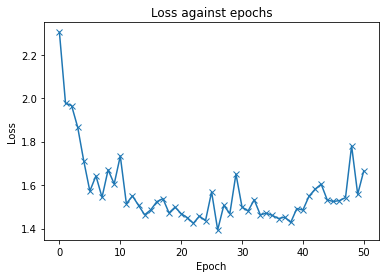

In [55]:
plot_losses(history)

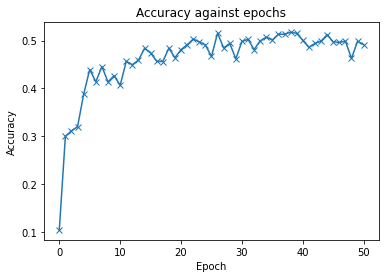

In [56]:
plot_accuracies(history)

Varying batch size: 64, 128, 256

In [57]:
# Baseline: 128

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

In [58]:
training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.301882028579712, 'validation_accuracy': 0.10141314566135406}]
Epoch 0 | validation_loss: 1.9352 | validation_accuracy: 0.2965
Epoch 1 | validation_loss: 1.8168 | validation_accuracy: 0.3515
Epoch 2 | validation_loss: 1.8015 | validation_accuracy: 0.3692
Epoch 3 | validation_loss: 1.6276 | validation_accuracy: 0.4212
Epoch 4 | validation_loss: 1.6937 | validation_accuracy: 0.3938
Epoch 5 | validation_loss: 1.5617 | validation_accuracy: 0.4413
Epoch 6 | validation_loss: 1.6317 | validation_accuracy: 0.4281
Epoch 7 | validation_loss: 1.6207 | validation_accuracy: 0.4264
Epoch 8 | validation_loss: 1.5797 | validation_accuracy: 0.4393
Epoch 9 | validation_loss: 1.4962 | validation_accuracy: 0.4695


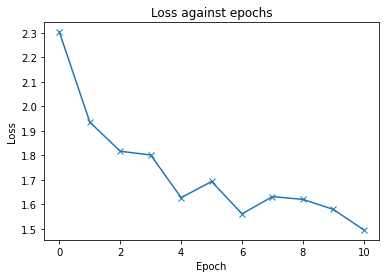

In [59]:
plot_losses(history)

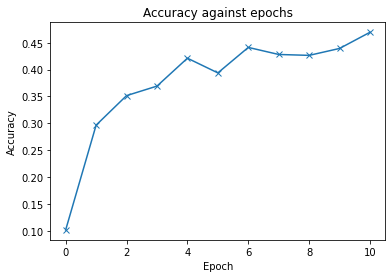

In [60]:
plot_accuracies(history)

In [61]:
# Lower: 64

batch_size = 64

training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3081135749816895, 'validation_accuracy': 0.09375}]
Epoch 0 | validation_loss: 1.8901 | validation_accuracy: 0.3154
Epoch 1 | validation_loss: 2.4256 | validation_accuracy: 0.2250
Epoch 2 | validation_loss: 1.8355 | validation_accuracy: 0.3299
Epoch 3 | validation_loss: 3.9734 | validation_accuracy: 0.2389
Epoch 4 | validation_loss: 1.9222 | validation_accuracy: 0.3354
Epoch 5 | validation_loss: 1.7598 | validation_accuracy: 0.3840
Epoch 6 | validation_loss: 1.6196 | validation_accuracy: 0.4209
Epoch 7 | validation_loss: 2.0434 | validation_accuracy: 0.3004
Epoch 8 | validation_loss: 1.7074 | validation_accuracy: 0.4203
Epoch 9 | validation_loss: 1.6562 | validation_accuracy: 0.4256


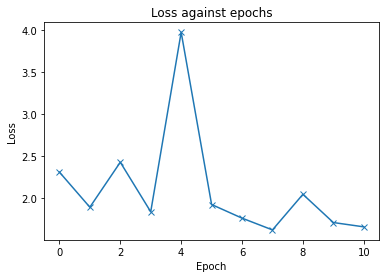

In [62]:
plot_losses(history)

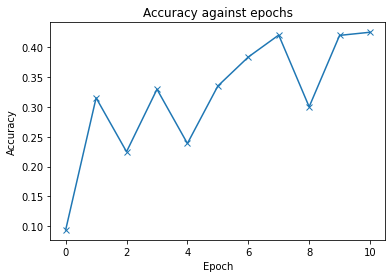

In [63]:
plot_accuracies(history)

In [64]:
# Higher: 256

batch_size = 256

training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.306365489959717, 'validation_accuracy': 0.09622927010059357}]
Epoch 0 | validation_loss: 1.9335 | validation_accuracy: 0.3123
Epoch 1 | validation_loss: 2.0122 | validation_accuracy: 0.2643
Epoch 2 | validation_loss: 1.7587 | validation_accuracy: 0.3670
Epoch 3 | validation_loss: 1.9449 | validation_accuracy: 0.3220
Epoch 4 | validation_loss: 1.6767 | validation_accuracy: 0.4079
Epoch 5 | validation_loss: 1.6501 | validation_accuracy: 0.4230
Epoch 6 | validation_loss: 1.6118 | validation_accuracy: 0.4351
Epoch 7 | validation_loss: 1.5734 | validation_accuracy: 0.4461
Epoch 8 | validation_loss: 1.6597 | validation_accuracy: 0.4120
Epoch 9 | validation_loss: 1.5460 | validation_accuracy: 0.4577


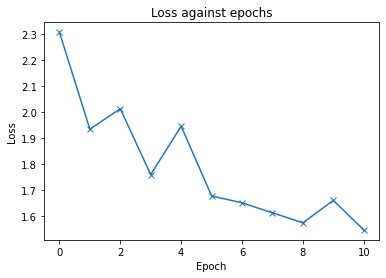

In [65]:
plot_losses(history)

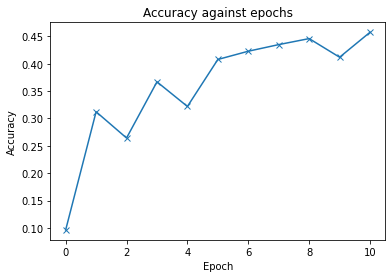

In [66]:
plot_accuracies(history)

Varying optimisation function: Stochastic Gradient Descent vs Adam

In [67]:
# Baseline: SGD

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3045852184295654, 'validation_accuracy': 0.09669961780309677}]
Epoch 0 | validation_loss: 2.0135 | validation_accuracy: 0.2617
Epoch 1 | validation_loss: 1.8820 | validation_accuracy: 0.3185
Epoch 2 | validation_loss: 1.8190 | validation_accuracy: 0.3486
Epoch 3 | validation_loss: 1.7212 | validation_accuracy: 0.3861
Epoch 4 | validation_loss: 1.6665 | validation_accuracy: 0.4108
Epoch 5 | validation_loss: 1.6202 | validation_accuracy: 0.4275
Epoch 6 | validation_loss: 1.5931 | validation_accuracy: 0.4363
Epoch 7 | validation_loss: 1.6219 | validation_accuracy: 0.4244
Epoch 8 | validation_loss: 1.5829 | validation_accuracy: 0.4423
Epoch 9 | validation_loss: 1.5335 | validation_accuracy: 0.4566


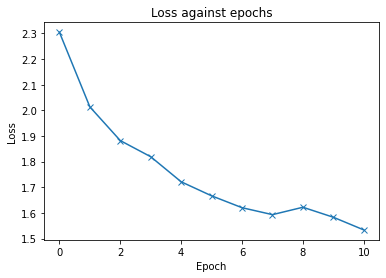

In [68]:
plot_losses(history)

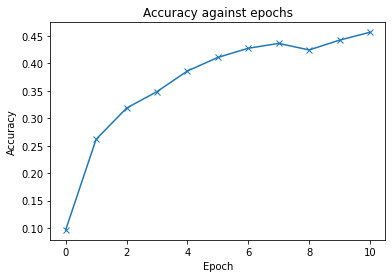

In [69]:
plot_accuracies(history)

In [70]:
# Alternative optimiser function: Adam

optimiser_function = torch.optim.Adam

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3045287132263184, 'validation_accuracy': 0.09902742505073547}]
Epoch 0 | validation_loss: 2.3077 | validation_accuracy: 0.0900
Epoch 1 | validation_loss: 2.3066 | validation_accuracy: 0.0931
Epoch 2 | validation_loss: 2.3065 | validation_accuracy: 0.0909
Epoch 3 | validation_loss: 2.3071 | validation_accuracy: 0.1003
Epoch 4 | validation_loss: 2.3053 | validation_accuracy: 0.1059
Epoch 5 | validation_loss: 2.3085 | validation_accuracy: 0.1006
Epoch 6 | validation_loss: 2.3083 | validation_accuracy: 0.0968
Epoch 7 | validation_loss: 2.3057 | validation_accuracy: 0.0934
Epoch 8 | validation_loss: 2.3079 | validation_accuracy: 0.0896
Epoch 9 | validation_loss: 2.3036 | validation_accuracy: 0.1012


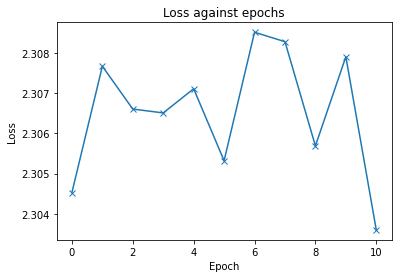

In [71]:
plot_losses(history)

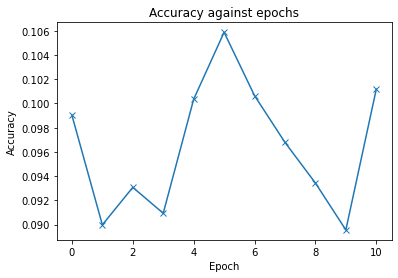

In [72]:
plot_accuracies(history)

Varying learning rate: 0.1, 0.01, 0.001

In [73]:
# Baseline: 0.1

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3019862174987793, 'validation_accuracy': 0.105277419090271}]
Epoch 0 | validation_loss: 1.9729 | validation_accuracy: 0.2922
Epoch 1 | validation_loss: 1.8534 | validation_accuracy: 0.3364
Epoch 2 | validation_loss: 1.7455 | validation_accuracy: 0.3694
Epoch 3 | validation_loss: 1.8061 | validation_accuracy: 0.3497
Epoch 4 | validation_loss: 1.6717 | validation_accuracy: 0.4143
Epoch 5 | validation_loss: 1.6052 | validation_accuracy: 0.4310
Epoch 6 | validation_loss: 1.7725 | validation_accuracy: 0.3885
Epoch 7 | validation_loss: 1.7105 | validation_accuracy: 0.4125
Epoch 8 | validation_loss: 1.5479 | validation_accuracy: 0.4507
Epoch 9 | validation_loss: 1.5613 | validation_accuracy: 0.4479


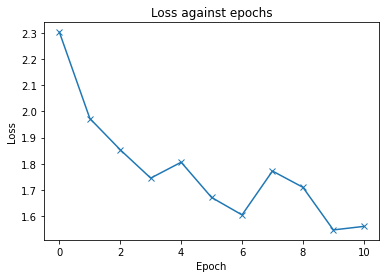

In [74]:
plot_losses(history)

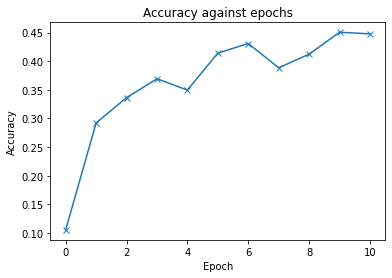

In [75]:
plot_accuracies(history)

In [76]:
# 0.01

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.01 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3105320930480957, 'validation_accuracy': 0.07955596596002579}]
Epoch 0 | validation_loss: 2.2302 | validation_accuracy: 0.1852
Epoch 1 | validation_loss: 2.1183 | validation_accuracy: 0.2476
Epoch 2 | validation_loss: 2.0290 | validation_accuracy: 0.2760
Epoch 3 | validation_loss: 1.9736 | validation_accuracy: 0.3028
Epoch 4 | validation_loss: 1.9366 | validation_accuracy: 0.3168
Epoch 5 | validation_loss: 1.9075 | validation_accuracy: 0.3294
Epoch 6 | validation_loss: 1.8900 | validation_accuracy: 0.3339
Epoch 7 | validation_loss: 1.8719 | validation_accuracy: 0.3424
Epoch 8 | validation_loss: 1.8556 | validation_accuracy: 0.3491
Epoch 9 | validation_loss: 1.8395 | validation_accuracy: 0.3569


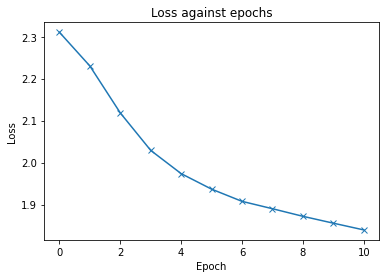

In [77]:
plot_losses(history)

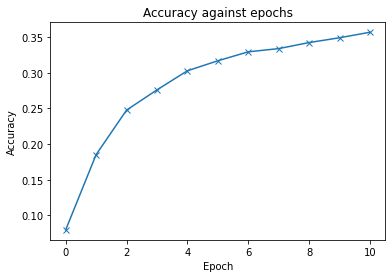

In [78]:
plot_accuracies(history)

In [79]:
# 0.001

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3015880584716797, 'validation_accuracy': 0.1095145121216774}]
Epoch 0 | validation_loss: 1.9672 | validation_accuracy: 0.2837
Epoch 1 | validation_loss: 1.8936 | validation_accuracy: 0.3140
Epoch 2 | validation_loss: 1.8131 | validation_accuracy: 0.3553
Epoch 3 | validation_loss: 1.7046 | validation_accuracy: 0.4026
Epoch 4 | validation_loss: 1.6807 | validation_accuracy: 0.4007
Epoch 5 | validation_loss: 1.6674 | validation_accuracy: 0.4090
Epoch 6 | validation_loss: 1.7446 | validation_accuracy: 0.3965
Epoch 7 | validation_loss: 1.5772 | validation_accuracy: 0.4509
Epoch 8 | validation_loss: 1.7213 | validation_accuracy: 0.3953
Epoch 9 | validation_loss: 1.6764 | validation_accuracy: 0.4127


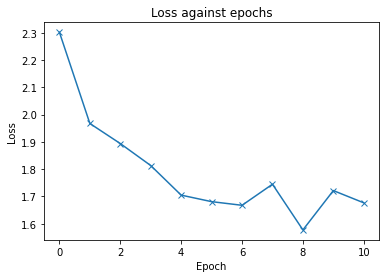

In [80]:
plot_losses(history)

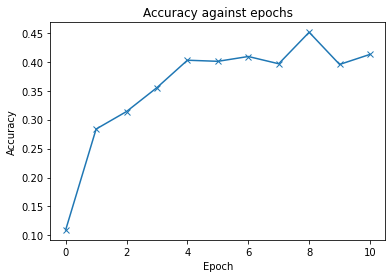

In [81]:
plot_accuracies(history)

Varying number of hidden layers: Baseline, two hidden, three hidden

In [82]:
# Baseline

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3029050827026367, 'validation_accuracy': 0.11376354843378067}]
Epoch 0 | validation_loss: 1.9372 | validation_accuracy: 0.3096
Epoch 1 | validation_loss: 1.8287 | validation_accuracy: 0.3466
Epoch 2 | validation_loss: 1.8080 | validation_accuracy: 0.3379
Epoch 3 | validation_loss: 1.7267 | validation_accuracy: 0.3919
Epoch 4 | validation_loss: 1.7195 | validation_accuracy: 0.3934
Epoch 5 | validation_loss: 1.8031 | validation_accuracy: 0.3744
Epoch 6 | validation_loss: 1.6040 | validation_accuracy: 0.4388
Epoch 7 | validation_loss: 1.5636 | validation_accuracy: 0.4549
Epoch 8 | validation_loss: 1.5499 | validation_accuracy: 0.4495
Epoch 9 | validation_loss: 1.5475 | validation_accuracy: 0.4502


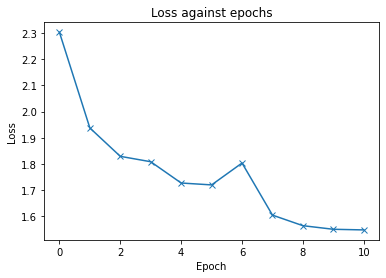

In [83]:
plot_losses(history)

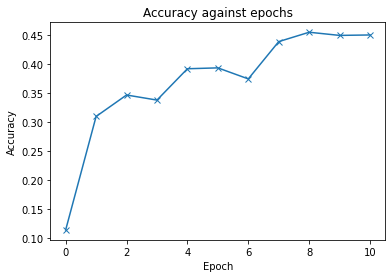

In [84]:
plot_accuracies(history)

In [85]:
# Two hidden layers

In [88]:
class Model_two_hidden(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        
        return x

In [89]:
model = move_to_device(Model_two_hidden(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3021397590637207, 'validation_accuracy': 0.12674185633659363}]
Epoch 0 | validation_loss: 1.9645 | validation_accuracy: 0.2845
Epoch 1 | validation_loss: 1.9025 | validation_accuracy: 0.3028
Epoch 2 | validation_loss: 1.8731 | validation_accuracy: 0.2968
Epoch 3 | validation_loss: 1.7524 | validation_accuracy: 0.3752
Epoch 4 | validation_loss: 1.6853 | validation_accuracy: 0.3965
Epoch 5 | validation_loss: 1.7395 | validation_accuracy: 0.3804
Epoch 6 | validation_loss: 1.6572 | validation_accuracy: 0.4039
Epoch 7 | validation_loss: 1.6123 | validation_accuracy: 0.4256
Epoch 8 | validation_loss: 1.5907 | validation_accuracy: 0.4334
Epoch 9 | validation_loss: 1.5784 | validation_accuracy: 0.4361


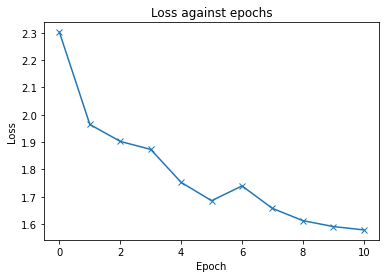

In [90]:
plot_losses(history)

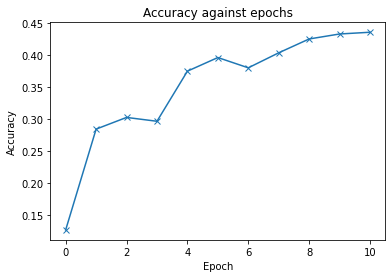

In [91]:
plot_accuracies(history)

In [92]:
class Model_three_hidden(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 128)
        self.linear5 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [93]:
model = move_to_device(Model_three_hidden(), device) 

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 4.841373443603516, 'validation_accuracy': 0.006098533049225807}]
Epoch 0 | validation_loss: 2.0137 | validation_accuracy: 0.2748
Epoch 1 | validation_loss: 1.8752 | validation_accuracy: 0.3147
Epoch 2 | validation_loss: 2.0648 | validation_accuracy: 0.2651
Epoch 3 | validation_loss: 1.8364 | validation_accuracy: 0.3424
Epoch 4 | validation_loss: 1.7297 | validation_accuracy: 0.3788
Epoch 5 | validation_loss: 1.6890 | validation_accuracy: 0.4107
Epoch 6 | validation_loss: 1.6923 | validation_accuracy: 0.3788
Epoch 7 | validation_loss: 1.6205 | validation_accuracy: 0.4273
Epoch 8 | validation_loss: 1.5725 | validation_accuracy: 0.4415
Epoch 9 | validation_loss: 1.5525 | validation_accuracy: 0.4473


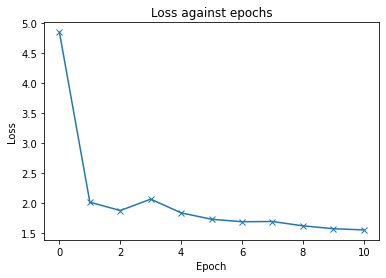

In [94]:
plot_losses(history)

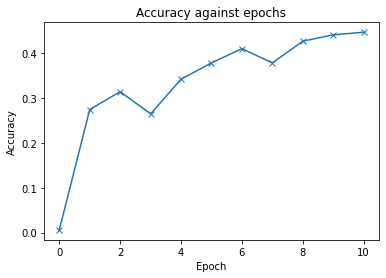

In [95]:
plot_accuracies(history)

Varying number of nodes in hidden layers

In [96]:
# Baseline

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.304050922393799, 'validation_accuracy': 0.0997488871216774}]
Epoch 0 | validation_loss: 2.0251 | validation_accuracy: 0.2599
Epoch 1 | validation_loss: 1.8133 | validation_accuracy: 0.3475
Epoch 2 | validation_loss: 1.7835 | validation_accuracy: 0.3593
Epoch 3 | validation_loss: 1.8352 | validation_accuracy: 0.3511
Epoch 4 | validation_loss: 1.7119 | validation_accuracy: 0.3823
Epoch 5 | validation_loss: 1.6415 | validation_accuracy: 0.4118
Epoch 6 | validation_loss: 1.6817 | validation_accuracy: 0.4026
Epoch 7 | validation_loss: 1.6041 | validation_accuracy: 0.4407
Epoch 8 | validation_loss: 1.6073 | validation_accuracy: 0.4319
Epoch 9 | validation_loss: 1.5546 | validation_accuracy: 0.4537


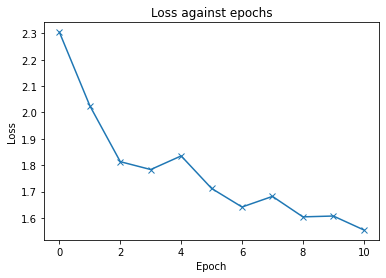

In [97]:
plot_losses(history)

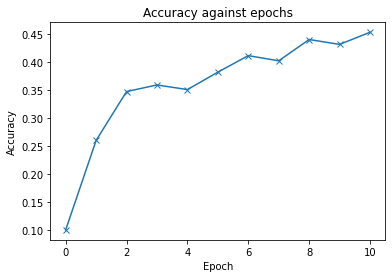

In [98]:
plot_accuracies(history)

In [99]:
# Fewer nodes

In [100]:
class Model_fewer_nodes(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [101]:
model = move_to_device(Model_fewer_nodes(), device) 

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3044495582580566, 'validation_accuracy': 0.10266263782978058}]
Epoch 0 | validation_loss: 1.9490 | validation_accuracy: 0.2991
Epoch 1 | validation_loss: 1.8283 | validation_accuracy: 0.3426
Epoch 2 | validation_loss: 1.7890 | validation_accuracy: 0.3574
Epoch 3 | validation_loss: 1.7867 | validation_accuracy: 0.3587
Epoch 4 | validation_loss: 1.7317 | validation_accuracy: 0.3739
Epoch 5 | validation_loss: 1.6483 | validation_accuracy: 0.4207
Epoch 6 | validation_loss: 1.6300 | validation_accuracy: 0.4216
Epoch 7 | validation_loss: 1.5950 | validation_accuracy: 0.4398
Epoch 8 | validation_loss: 1.7819 | validation_accuracy: 0.3668
Epoch 9 | validation_loss: 1.5437 | validation_accuracy: 0.4529


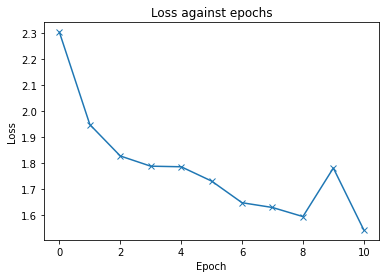

In [102]:
plot_losses(history)

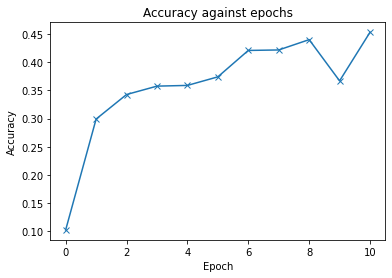

In [103]:
plot_accuracies(history)

In [104]:
# More nodes

In [105]:
class Model_more_nodes(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [106]:
model = move_to_device(Model_more_nodes(), device) 

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.304974317550659, 'validation_accuracy': 0.10784438997507095}]
Epoch 0 | validation_loss: 1.9393 | validation_accuracy: 0.3063
Epoch 1 | validation_loss: 1.8927 | validation_accuracy: 0.3143
Epoch 2 | validation_loss: 1.7618 | validation_accuracy: 0.3724
Epoch 3 | validation_loss: 1.6830 | validation_accuracy: 0.4046
Epoch 4 | validation_loss: 1.6472 | validation_accuracy: 0.4189
Epoch 5 | validation_loss: 1.6321 | validation_accuracy: 0.4097
Epoch 6 | validation_loss: 1.5979 | validation_accuracy: 0.4219
Epoch 7 | validation_loss: 1.6046 | validation_accuracy: 0.4302
Epoch 8 | validation_loss: 1.6944 | validation_accuracy: 0.3938
Epoch 9 | validation_loss: 1.5297 | validation_accuracy: 0.4680


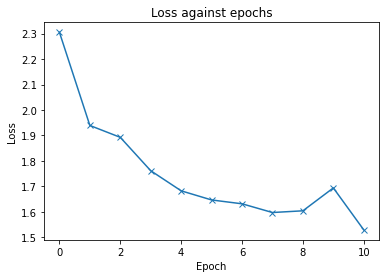

In [107]:
plot_losses(history)

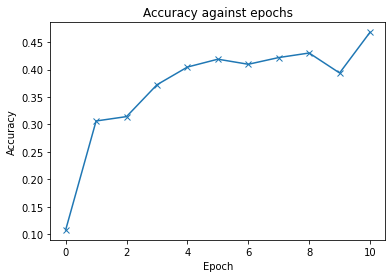

In [108]:
plot_accuracies(history)